# GDP Forecasting

This project focuses on the analysis and the forecasting of the total GDP (Gross Domestic Product) for the last decade (2010-2020) in five different countries: Canada, China, Italy, Japan, and the United States.
The dataset contains estimates of total GDP and its components across 220 countries, with 17 derived indicators, covering the period from 1970 to 2020.

### Objectives:

1. **Forecasting Models:** Using various models such as Linear Regression, ETS models (Error, Trend, Seasonality), and ARIMA (AutoRegressive Integrated Moving Average) for GDP prediction.
  
2. **Comparing the forecasting models based on two key metrics:** AIC (Akaike Information Criterion) and RMSE (Root Mean Squared Error). This evaluation will provide insights into the accuracy and goodness of fit for each model.

3. **Variable Analysis:** Beyond GDP, the project aims to analyze and visualize additional variables for each country, including Exports, Imports, Manufacturing (ISIC D), and Gross Capital Formation. These variables contribute to a holistic understanding of the economic landscape.

The comprehensive analysis and forecasting for these key economic indicators will contribute to a deeper understanding of the economic trends and dynamics in the specified countries, facilitating informed decision-making and strategic planning.

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from scipy import stats, signal
from numpy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

# Visualization libraries
import seaborn as sns
import seaborn; seaborn.set()
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go




In [57]:
# Upload the dataset
gdp_df= pd.read_excel('/Users/GaiaTravaglini/Desktop/Project/GDPcountries.xlsx', header=2)
gdp_df.head(5)

,CountryID,Country,IndicatorName,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,4.0,Afghanistan,Final consumption expenditure,3.068715e+09,2.957075e+09,2.886788e+09,3.100416e+09,3.328662e+09,3.514642e+09,3.587322e+09,...,1.153494e+10,1.537617e+10,1.849492e+10,1.856572e+10,1.912682e+10,1.930930e+10,1.813094e+10,2.154508e+10,2.494428e+10,2.210259e+10
1,4.0,Afghanistan,Household consumption expenditure (including N...,2.734161e+09,2.614420e+09,2.529175e+09,2.724908e+09,2.941860e+09,3.012107e+09,3.032225e+09,...,8.263218e+09,1.170813e+10,1.463690e+10,1.460849e+10,1.497766e+10,1.494902e+10,1.404900e+10,1.767663e+10,1.998886e+10,1.835413e+10
2,4.0,Afghanistan,General government final consumption expenditure,3.288787e+08,3.375334e+08,3.530078e+08,3.704164e+08,3.810549e+08,4.980797e+08,5.512724e+08,...,3.284910e+09,3.673733e+09,3.855382e+09,3.956030e+09,4.149161e+09,4.363228e+09,4.084496e+09,3.854648e+09,4.947607e+09,3.730520e+09
3,4.0,Afghanistan,Gross capital formation,1.654637e+09,1.764946e+09,1.615795e+09,1.566079e+09,1.914097e+09,2.257143e+09,3.214193e+09,...,3.424102e+09,3.502218e+09,3.362394e+09,2.670612e+09,2.564176e+09,2.570764e+09,2.781503e+09,3.190771e+09,2.640315e+09,3.441861e+09
4,4.0,Afghanistan,Gross fixed capital formation (including Acqui...,1.653901e+09,1.764161e+09,1.543641e+09,1.543641e+09,1.984681e+09,2.293410e+09,3.418062e+09,...,3.318640e+09,3.518975e+09,3.286279e+09,2.474054e+09,2.564176e+09,2.547500e+09,2.756332e+09,3.161896e+09,2.616422e+09,3.410714e+09


### Data Cleaning

In [58]:
#Drop unuseful columns and rename NameIndicator
gdp_df.drop(['CountryID'], axis=1, inplace=True)
gdp_df.rename(columns={'IndicatorName':'Name_indicator'}, inplace=True)
gdp_df.head()


,Country,Name_indicator,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Afghanistan,Final consumption expenditure,3.068715e+09,2.957075e+09,2.886788e+09,3.100416e+09,3.328662e+09,3.514642e+09,3.587322e+09,3.825474e+09,...,1.153494e+10,1.537617e+10,1.849492e+10,1.856572e+10,1.912682e+10,1.930930e+10,1.813094e+10,2.154508e+10,2.494428e+10,2.210259e+10
1,Afghanistan,Household consumption expenditure (including N...,2.734161e+09,2.614420e+09,2.529175e+09,2.724908e+09,2.941860e+09,3.012107e+09,3.032225e+09,3.230522e+09,...,8.263218e+09,1.170813e+10,1.463690e+10,1.460849e+10,1.497766e+10,1.494902e+10,1.404900e+10,1.767663e+10,1.998886e+10,1.835413e+10
2,Afghanistan,General government final consumption expenditure,3.288787e+08,3.375334e+08,3.530078e+08,3.704164e+08,3.810549e+08,4.980797e+08,5.512724e+08,5.909253e+08,...,3.284910e+09,3.673733e+09,3.855382e+09,3.956030e+09,4.149161e+09,4.363228e+09,4.084496e+09,3.854648e+09,4.947607e+09,3.730520e+09
3,Afghanistan,Gross capital formation,1.654637e+09,1.764946e+09,1.615795e+09,1.566079e+09,1.914097e+09,2.257143e+09,3.214193e+09,3.311137e+09,...,3.424102e+09,3.502218e+09,3.362394e+09,2.670612e+09,2.564176e+09,2.570764e+09,2.781503e+09,3.190771e+09,2.640315e+09,3.441861e+09
4,Afghanistan,Gross fixed capital formation (including Acqui...,1.653901e+09,1.764161e+09,1.543641e+09,1.543641e+09,1.984681e+09,2.293410e+09,3.418062e+09,3.219594e+09,...,3.318640e+09,3.518975e+09,3.286279e+09,2.474054e+09,2.564176e+09,2.547500e+09,2.756332e+09,3.161896e+09,2.616422e+09,3.410714e+09


In [59]:
# Check for the total na values
print(f'Total missing values:',gdp_df.isna().sum().sum())

Total missing values: 15798


In [60]:
# Melt the different date columns together to get a single column (Date)
gdp_df_melted = gdp_df.melt(id_vars =['Country', 'Name_indicator'],
                var_name = 'Date',
                value_name = 'Value').dropna()

display(gdp_df_melted.head(10))

print('---------------------------------------------------------------------')

if gdp_df_melted.isna().sum().sum() == 0:
  print ('There are no missing values')

else:
  print ('There are still', gdp_df_melted.isna().sum().sum(),'missing values' )



,Country,Name_indicator,Date,Value
0,Afghanistan,Final consumption expenditure,1970.0,3.068715e+09
1,Afghanistan,Household consumption expenditure (including N...,1970.0,2.734161e+09
2,Afghanistan,General government final consumption expenditure,1970.0,3.288787e+08
3,Afghanistan,Gross capital formation,1970.0,1.654637e+09
4,Afghanistan,Gross fixed capital formation (including Acqui...,1970.0,1.653901e+09
5,Afghanistan,Exports of goods and services,1970.0,1.546737e+08
6,Afghanistan,Imports of goods and services,1970.0,1.622465e+08
7,Afghanistan,Gross Domestic Product (GDP),1970.0,1.046759e+10
8,Afghanistan,"Agriculture, hunting, forestry, fishing (ISIC ...",1970.0,7.797721e+09
9,Afghanistan,"Mining, Manufacturing, Utilities (ISIC C-E)",1970.0,1.029146e+09


---------------------------------------------------------------------
There are no missing values


In [61]:
# Insights on the data
display('Data type:', gdp_df_melted.dtypes)

'Data type:'

Country            object
Name_indicator     object
Date               object
Value             float64
dtype: object

### Data Processing

In [62]:
#setting Date as index
gdp_df_melted['Date'] = pd.to_datetime(gdp_df_melted['Date'].astype(str).str.replace(r'\.0$', ''), format="%Y") #convert the Date variable into Datatime
gdp_df_melted= gdp_df_melted.set_index(gdp_df_melted ['Date'])
gdp_df_melted.drop(['Date'], axis=1, inplace=True) #Drop the date column since now it is an index
gdp_df_melted.head()

,Country,Name_indicator,Value
Date,,,
1970-01-01,Afghanistan,Final consumption expenditure,3.068715e+09
1970-01-01,Afghanistan,Household consumption expenditure (including N...,2.734161e+09
1970-01-01,Afghanistan,General government final consumption expenditure,3.288787e+08
1970-01-01,Afghanistan,Gross capital formation,1.654637e+09
1970-01-01,Afghanistan,Gross fixed capital formation (including Acqui...,1.653901e+09


### Data Filtering

In [63]:
#Focusing on 5 different countries: Italy, Germany, United States, China, Japan
countries = ['Italy', 'Canada', 'United States', 'China', 'Japan']

gdp_sub_df = gdp_df_melted[(gdp_df_melted['Country'].apply(lambda x: x in countries))]

gdp_sub_df.head()

,Country,Name_indicator,Value
Date,,,
1970-01-01,Canada,Final consumption expenditure,3.650572e+11
1970-01-01,Canada,Household consumption expenditure (including N...,2.313812e+11
1970-01-01,Canada,General government final consumption expenditure,1.345398e+11
1970-01-01,Canada,Gross capital formation,7.610953e+10
1970-01-01,Canada,Gross fixed capital formation (including Acqui...,8.172876e+10


The next step is to focus on the following subset of variables besides GDP:
- Exports
- Imports
- Manufacturing
- Gross Capital

In [64]:
categories = ['Gross Domestic Product (GDP)', 'Exports of goods and services', 'Imports of goods and services','Manufacturing (ISIC D)','Gross capital formation']
gdp_sub_df= gdp_sub_df[gdp_sub_df['Name_indicator'].apply(lambda x: x in categories)]
gdp_sub_df.head()

,Country,Name_indicator,Value
Date,,,
1970-01-01,Canada,Gross capital formation,7.610953e+10
1970-01-01,Canada,Exports of goods and services,8.092115e+10
1970-01-01,Canada,Imports of goods and services,6.375635e+10
1970-01-01,Canada,Gross Domestic Product (GDP),4.581051e+11
1970-01-01,Canada,Manufacturing (ISIC D),6.596572e+10


### Data Analysis

The conducted data analysis focuses on the previously selected 5 countries

In [65]:
fig = make_subplots()

for country in gdp_sub_df['Country'].unique():
    country_df = gdp_sub_df[gdp_sub_df['Country'] == country]

    for category in country_df['Name_indicator'].unique():
        category_df = country_df[country_df['Name_indicator'] == category]

        # Add scatter trace for the category
        trace = go.Scatter(x=category_df.index,
                           y=category_df['Value'],
                           mode='lines+markers',
                           name=category)
        fig.add_trace(trace)

# Adding buttons for each country and category
updatemenus = []
buttons = []

for i, country in enumerate(gdp_sub_df['Country'].unique()):
    visible = [False] * len(fig.data)
    visible[i * 5: (i + 1) * 5] = [True] * 5  # Show traces for the current country

    buttons.append(
        dict(args=[{'visible': visible},
                    {'title': f'Scatter Plot for {country}'}],
             label=country,
             method='update'))

# Set configurations for the buttons
updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.175,
                'xanchor': 'right',
                'y': 1.10,
                'yanchor': 'top'}]

# Adding labels and title
fig.update_layout(
    title='Scatter Plot for the 5 Categories',
    xaxis_title='Date',
    yaxis_title='Value',
    updatemenus=updatemenus,
    height=600,
    width=800
)

fig.show()


For each selected country, we can look at the distribution in time of each category.

We can notice that for every country there seems to be a strict correlation between imports and exports.\
We can verify by defining the correlation function

In [66]:
# Filter for one dataset

pivot_df = gdp_sub_df[gdp_sub_df['Country'] == 'Canada']
pivot = pd.pivot_table(data=pivot_df, index='Date',columns='Name_indicator', values='Value')
pivot.head(5)
pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 1970-01-01 to 2020-01-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Exports of goods and services  51 non-null     float64
 1   Gross Domestic Product (GDP)   51 non-null     float64
 2   Gross capital formation        51 non-null     float64
 3   Imports of goods and services  51 non-null     float64
 4   Manufacturing (ISIC D)         51 non-null     float64
dtypes: float64(5)
memory usage: 2.4 KB


Text(0, 0.5, 'Imports of goods and services \n(hundred billions)')

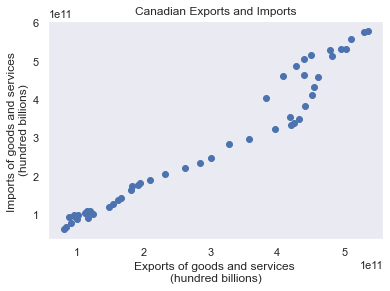

In [67]:
#scatter plot of Canadian exports and imports

plt.scatter(pivot['Exports of goods and services'], pivot['Imports of goods and services'])
plt.grid()
plt.title("Canadian Exports and Imports")
plt.xlabel('Exports of goods and services \n(hundred billions)')
plt.ylabel('Imports of goods and services \n(hundred billions)')

In [68]:
def correlation(x,y):
  A = np.sum((x-np.mean(x))*(y-np.mean(y)))
  B = np.sum((x-np.mean(x))**2) *np.sum((y-np.mean(y))**2)
  corr = A/(B)**0.5
  return(corr)

In [69]:
#Correlation between Exports and Imports
x = pivot['Exports of goods and services']
y = pivot['Imports of goods and services']

corr = correlation(x,y)
print('Correlation value is:', corr)

Correlation value is: 0.9743127602721039


In [70]:
#Correlation between GDP and Manufacturing
x = pivot['Gross Domestic Product (GDP)']
y = pivot['Manufacturing (ISIC D)']

corr = correlation(x,y)
print('Correlation value is:', corr)

Correlation value is: 0.9005082876145032


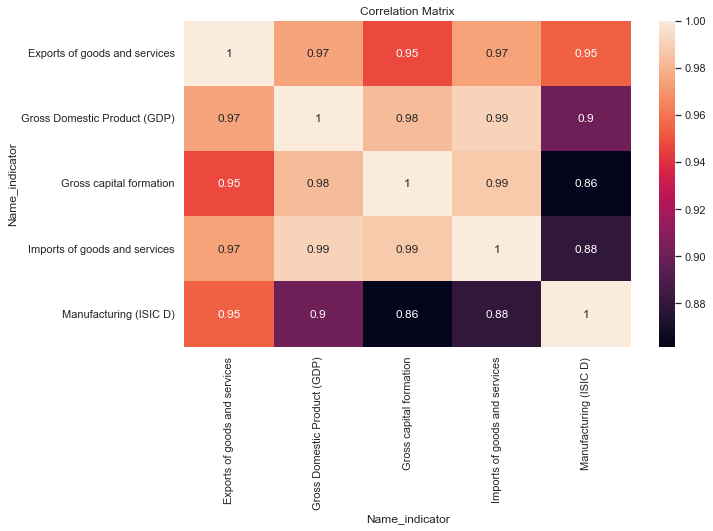

In [71]:
#Correlation Matrix -> check if all the variables might be correlated with each others
fig, ax = plt.subplots(figsize=(10, 6))
corr_mat = pivot.corr()
sns.heatmap(corr_mat, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [72]:
# GDP Analysis

fig = go.Figure()

for country in gdp_sub_df['Country'].unique():
    country_df = gdp_sub_df[(gdp_sub_df['Country'] == country) & (gdp_sub_df['Name_indicator'] == 'Gross Domestic Product (GDP)')]

    trace = go.Scatter(
        x=country_df.index,
        y=country_df['Value'],
        mode='lines+markers',
        name=country
    )
    fig.add_trace(trace)

# Adding labels and title
fig.update_layout(
    title='Scatter Plot for Gross Domestic Product (GDP)',
    xaxis_title='Date',
    yaxis_title='Value'
)

fig.show()

It is also useful to catch more information about the autocorrelation of the GDP for a specific country in different time steps.

In [73]:
# Filter for the GDP of Canada
gdp_signal = pivot['Gross Domestic Product (GDP)']

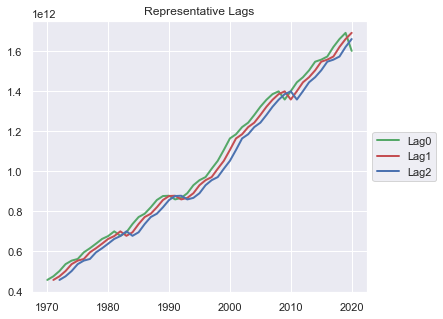

In [74]:
# Look at the lag version of the original signal
gdp_signals = [{'name': 'Lag0', 'y': gdp_signal,'color':'g', 'linewidth':2}, #original signal
              {'name': 'Lag1', 'y': gdp_signal.shift(1),'color':'r', 'linewidth':2}, #shifted by t+1
            {'name': 'Lag2', 'y':  gdp_signal.shift(2),'color':'b', 'linewidth':2}] #shifted by t+2

fig, ax = plt.subplots(figsize=(6,5))
for line_lag in gdp_signals:
    ax.plot(line_lag['y'],
            color=line_lag['color'],
            linewidth=line_lag['linewidth'],
            label=line_lag['name'])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Representative Lags');

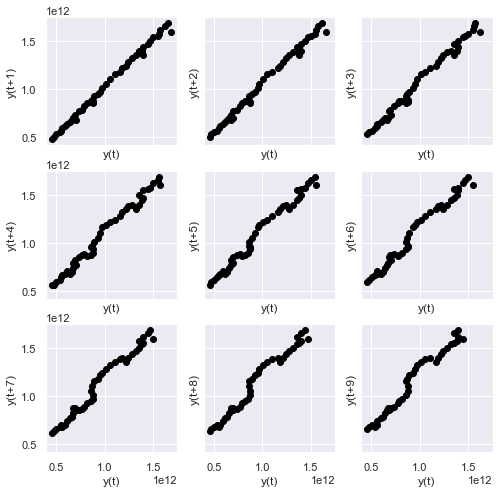

In [75]:
# Lag plots for the Canadian GDP
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))

for i, ax in enumerate(axes.flatten()[:9]):
    pd.plotting.lag_plot(gdp_signal, lag=i+1, ax=ax, c='black')
    ax.set_xlabel("y(t)")
    ax.set_ylabel("y(t+"+str(i+1)+")")

The lag plot suggests for strong positive autocorrelation

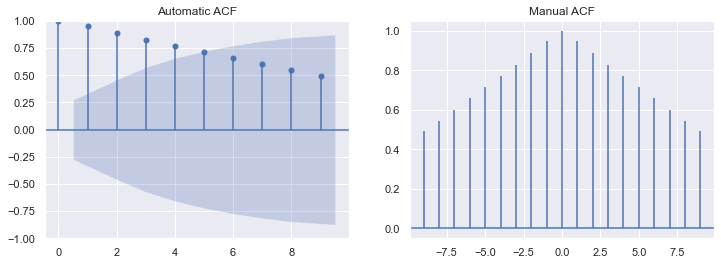

In [76]:
# Using both Automatic ACF and Manual ACF

signal_demean = gdp_signal - gdp_signal.mean() # Signal has to be demean in the manual version (this is automatically done in the plot_acf function)
n = np.array(signal_demean,dtype = float)

fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(gdp_signal, lags=9, ax = ax[0])
ax[0].set_title('Automatic ACF')

ax[1]=plt.acorr(n,normed = True, maxlags = 9)
ax[1] = plt.title('Manual ACF')

Again, the autocorrelation of GDP seems to be high for all the lags, especially for the first ones.
It is possibile to expand this insight about autocorrelation to understand if all the other variables present the same patten

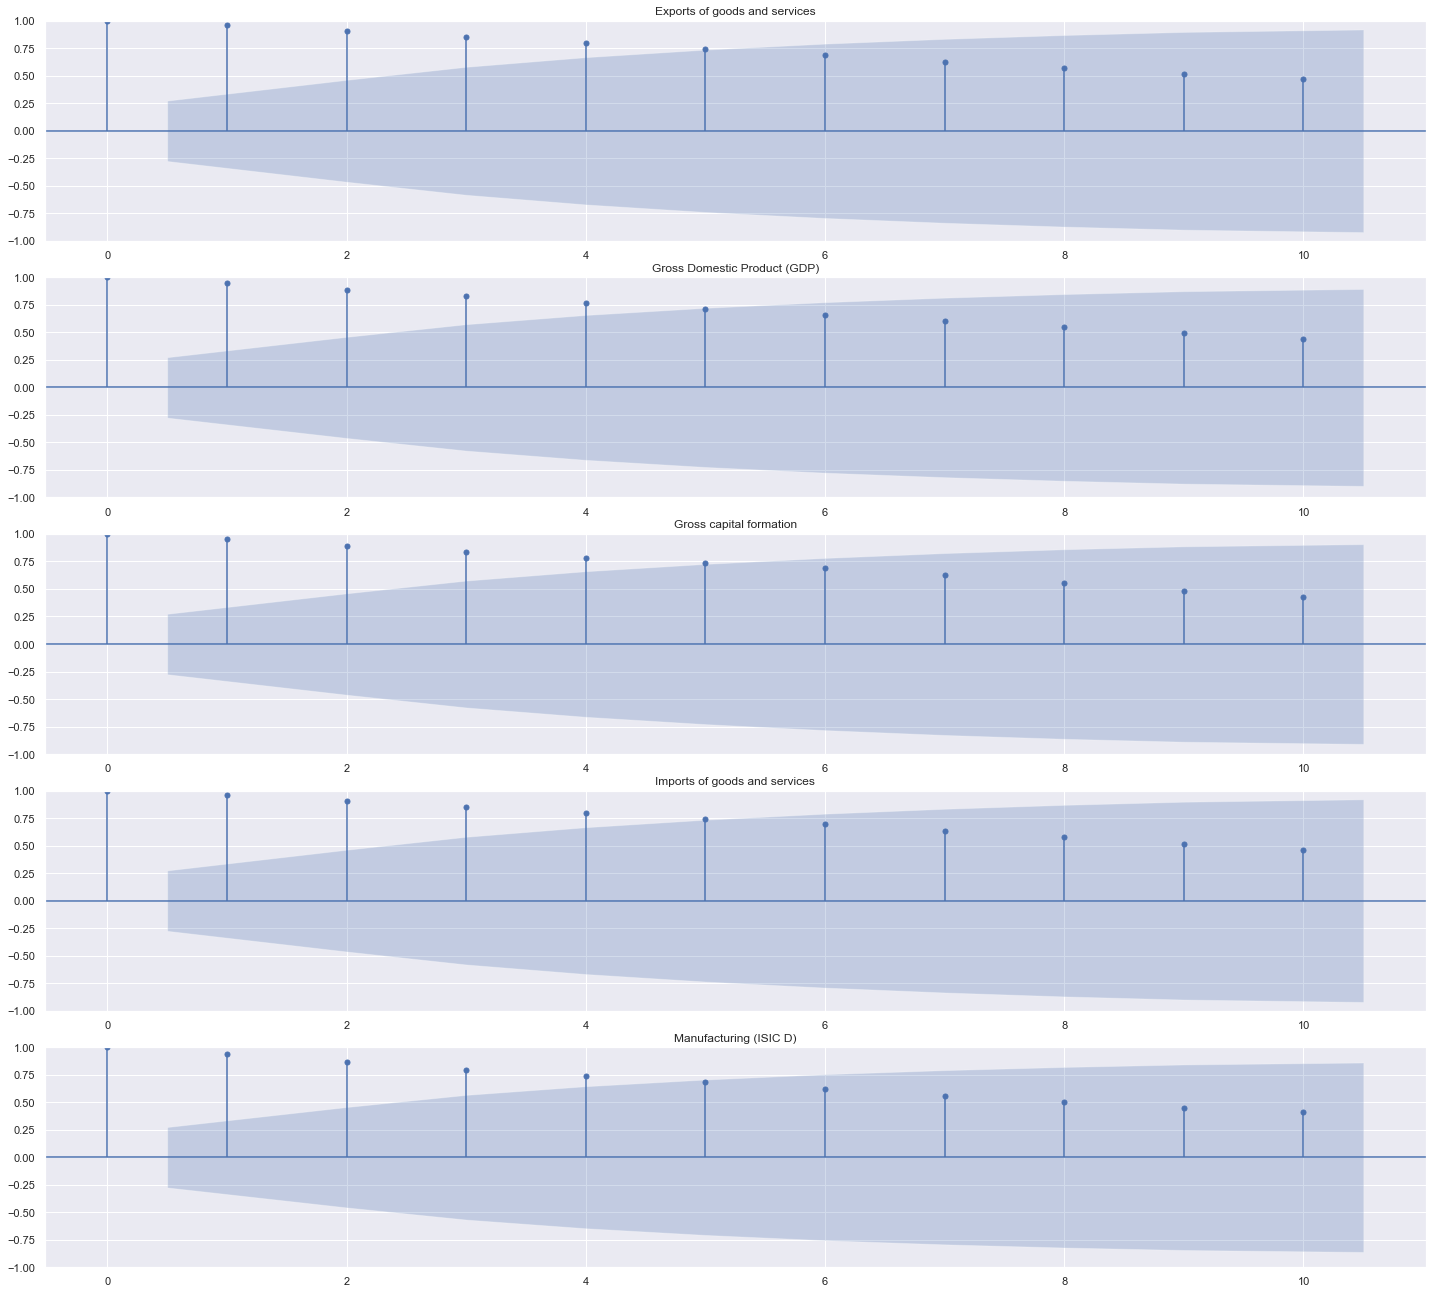

In [77]:
#ACF for all Canadian variables
n = 5
fig, axes = plt.subplots(n, int(len(pivot.columns)/n), figsize=(20, 18))
fig.tight_layout()

# Plot ACF for all Canadian variables
for i, ax in enumerate(axes.flatten()):
    variable_name = pivot.columns[i]
    plot_acf(pivot[variable_name], lags=10, ax=ax, title=variable_name)

plt.show()

Besides the analysis of each country GDP, a more relevant analysis could be done by looking at the nominal GDP the Nominal GDP and the GDP per capita of each country.

In [78]:
# Get GDP per Capita Dataset (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD )

gdp_capita_df= pd.read_csv('/Users/GaiaTravaglini/Desktop/Project/all_countries_gdp_per-capita.csv',  delimiter=',', header=2)

gdp_capita_df.drop(columns={'Country Code','Indicator Code', 'Indicator Name'}, axis=1, inplace=True)
gdp_capita_melted_df = gdp_capita_df.melt(id_vars =['Country Name'],
                var_name = 'Date',
                value_name = 'GDP per Capita').dropna()

gdp_capita_melted_df['Date']= pd.to_datetime(gdp_capita_melted_df['Date'], format= "%Y") #convert the Date variable into Datatime
gdp_capita_melted_df= gdp_capita_melted_df.set_index(gdp_capita_melted_df['Date'])
gdp_capita_melted_df.drop(['Date'], axis=1, inplace=True) #Drop the date column since now it is an index
gdp_capita_melted_df.head()

# Filtering
countries = ['Italy', 'Canada', 'United States', 'China', 'Japan']
gdp_capita_sub_df = gdp_capita_melted_df[gdp_capita_melted_df['Country Name'].apply(lambda x: x in countries)]
gdp_capita_sub_df.head()

,Country Name,GDP per Capita
Date,,
1960-01-01,Canada,2259.250511
1960-01-01,China,89.520214
1960-01-01,Italy,804.492623
1960-01-01,Japan,475.319076
1960-01-01,United States,3007.123445


In [79]:
# Filter the original dataset for the indicator GDP
nominal_gdp = gdp_sub_df[gdp_sub_df['Name_indicator'] == 'Gross Domestic Product (GDP)']

# Merge the two dataset and apply the necessary transformation
merged_df = pd.merge(gdp_capita_sub_df, nominal_gdp[['Country','Value']], how='right', left_on=['Country Name',gdp_capita_sub_df.index ], right_on=['Country', nominal_gdp.index])
merged_df.rename(columns={'key_1':'Date','Value':'Nominal GDP'}, inplace= True)
merged_df.drop(['Country Name'], axis=1, inplace=True)
merged_df = merged_df[['Date', 'Country', 'Nominal GDP', 'GDP per Capita']]

merged_df = merged_df.reset_index()
merged_df.drop(['index'], axis=1, inplace=True)
merged_df= merged_df[merged_df['Date'] == '2020-01-01']
merged_df.head()



,Date,Country,Nominal GDP,GDP per Capita
250,2020-01-01,Canada,1.599940e+12,43349.677856
251,2020-01-01,China,1.463198e+13,10408.719554
252,2020-01-01,Italy,1.744732e+12,31922.919163
253,2020-01-01,Japan,4.380757e+12,39986.928629
254,2020-01-01,United States,1.924706e+13,63528.634303


In [80]:
df = merged_df.sort_values('Nominal GDP')
new_gdp = merged_df.sort_values('GDP per Capita')

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=['GDP 2020', 'GDP per capita 2020'],column_widths=[0.5, 0.5])

# Add bar plot for Nominal GDP
fig.add_trace(go.Bar(x=df['Country'], y=df['Nominal GDP'], name='Nominal GDP'), row=1, col=1)
fig.update_xaxes(title_text='Country', row=1, col=1)
fig.update_yaxes(title_text='Nominal GDP', row=1, col=1)

# Add bar plot for GDP per Capita
fig.add_trace(go.Bar(x=new_gdp['Country'], y=new_gdp['GDP per Capita'], name='GDP per Capita'), row=1, col=2)
fig.update_xaxes(title_text='Country', row=1, col=2)
fig.update_yaxes(title_text='GDP per Capita', row=1, col=2)

# Update layout
fig.update_layout(showlegend=False, title_text='Comparison between Nominal GDP and GDP per Capita', height=500, width=1000)

# Show the plot
fig.show()



#### Frequency Analysis

,Freq,Period,Power
0,0.156863,6.3750,9.062658e+22
1,0.235294,4.2500,3.791621e+22
2,0.313725,3.1875,1.883386e+22
3,0.392157,2.5500,1.407405e+22


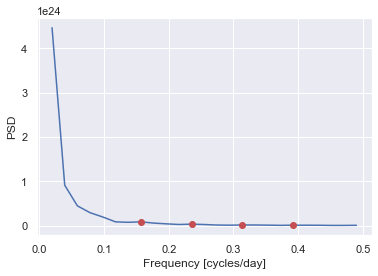

In [81]:
from scipy import signal

#PSD using the raw periodogram
Fs = 1 #The unit of measure to consider is "years", thus 1 per year
f_per, Pxx_per = signal.periodogram(gdp_signal,Fs,detrend=None,window=None,return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.ylabel('PSD')
plt.xlabel('Frequency [cycles/day]');

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro');

signal = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
signal_df = pd.DataFrame(signal)
display(signal_df )

6 peaks:(12, 7, 5, 4, 3, 2 years) repetition of data

,Freq,Period,Power
0,0.058824,17.0000,1.023288e+23
1,0.156863,6.3750,1.545538e+22
2,0.235294,4.2500,5.333305e+21
3,0.313725,3.1875,2.376568e+21
4,0.392157,2.5500,1.837721e+21


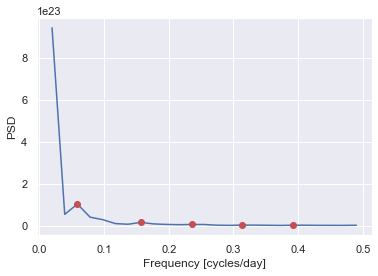

In [82]:
from scipy import signal

signal_imp = pivot['Exports of goods and services']

Fs = 1 #our unit of measure is "years", thus 1 per year
f_per, Pxx_per = signal.periodogram(signal_imp,Fs,detrend=None,window=None,return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.ylabel('PSD')
plt.xlabel('Frequency [cycles/day]');

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro');

signal = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
signal_df = pd.DataFrame(signal)
display(signal_df )

## Pattern Analysis

### Decomposition

In [83]:
#Canadian GDP dataset
canada_gdp = pivot_df[pivot_df['Name_indicator'] == 'Gross Domestic Product (GDP)'	]
canada_gdp = canada_gdp.drop(['Country',	'Name_indicator'], axis=1)
canada_gdp.head(5)

,Value
Date,
1970-01-01,4.581051e+11
1971-01-01,4.762930e+11
1972-01-01,5.025352e+11
1973-01-01,5.368873e+11
1974-01-01,5.544989e+11


In [84]:
display(canada_gdp.index)
canada_gdp = canada_gdp.asfreq('AS') #annual indexing, 'AS' for start of year
canada_gdp.index

DatetimeIndex(['1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

DatetimeIndex(['1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', freq='AS-JAN')

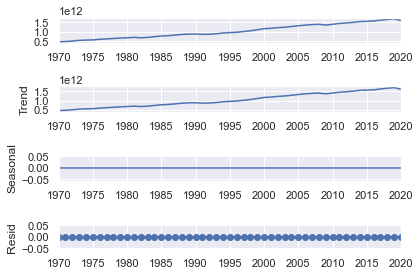

In [85]:
#Decomposing Canadian GDP
decompose_data_add = seasonal_decompose(canada_gdp, model='additive')
decompose_data_add.plot()
plt.show()

From the first two plots, it seems that the TS is entirely taken as the trend component with no seasonality at all. \
In addition, also the residual plot shows zero. \
This may be due to the fact that the classical decomposition was not able to separate the noise added from the linear trend. \
One possible cause seems to be the yearly frequency of the TS (period =1).

We can check if the same results is obtained for other variables:

In [86]:
# First, resample other variables
canada_exp = pivot['Exports of goods and services'].asfreq('AS')
canada_imp = pivot['Imports of goods and services'].asfreq('AS')
canada_gcf= pivot['Gross capital formation'].asfreq('AS')
canada_man = pivot['Manufacturing (ISIC D)'].asfreq('AS')

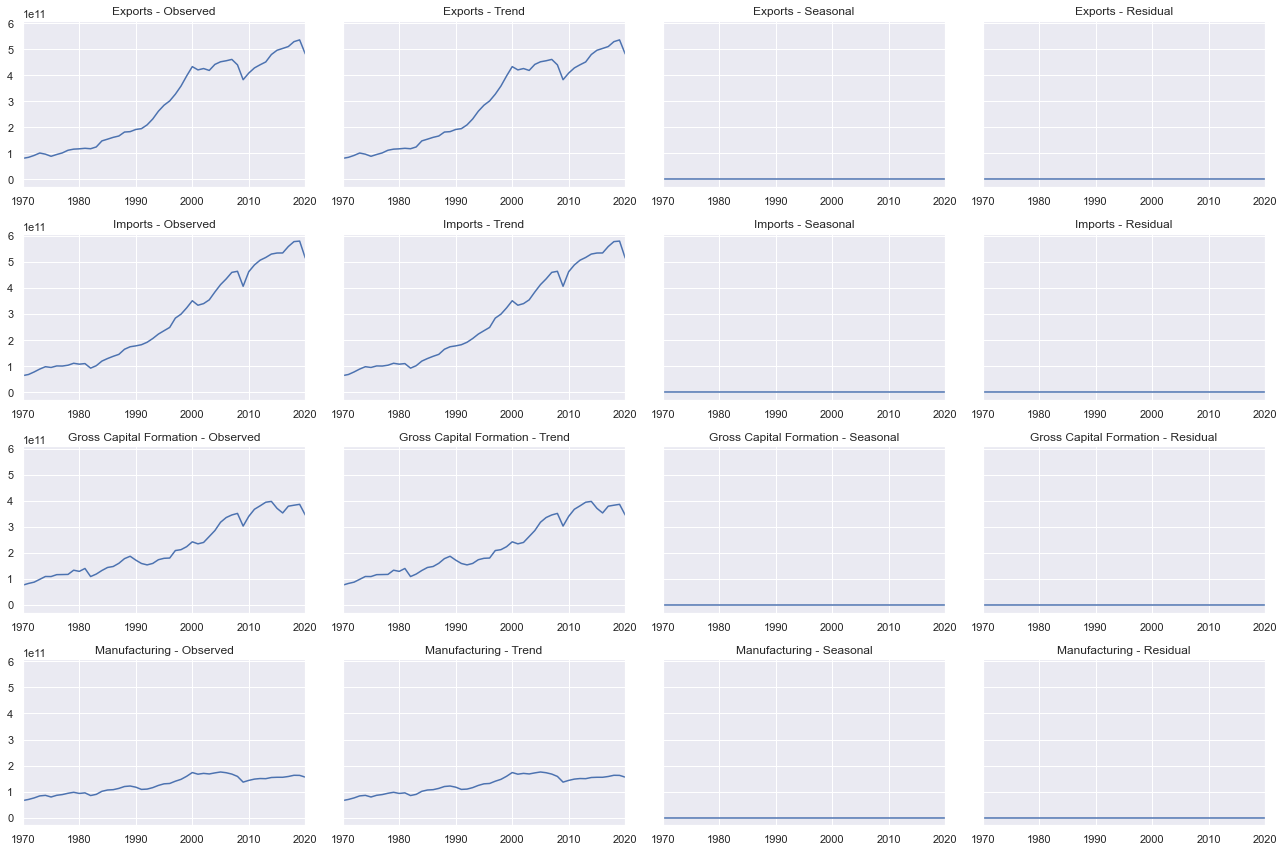

In [87]:
def plot_seasonal(res, axes, title):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_title(f'{title} - Observed')
    axes[0].set_xlabel('')

    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_title(f'{title} - Trend')
    axes[1].set_xlabel('')

    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_title(f'{title} - Seasonal')
    axes[2].set_xlabel('')

    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_title(f'{title} - Residual')
    axes[3].set_xlabel('')

# Decompose the other variables
decompose_exports = seasonal_decompose(canada_exp, model='additive')
decompose_imports = seasonal_decompose(canada_imp, model='additive')
decompose_gcf = seasonal_decompose(canada_gcf, model='additive')
decompose_man = seasonal_decompose(canada_man, model='additive')

# Create subplots for each variable
fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(18, 12))
plot_seasonal(decompose_exports, axes[0, :], 'Exports')
plot_seasonal(decompose_imports, axes[1, :], 'Imports')
plot_seasonal(decompose_gcf, axes[2, :], 'Gross Capital Formation')
plot_seasonal(decompose_man, axes[3, :], 'Manufacturing')

plt.tight_layout()
plt.show()


Again, the same pattern exploited with the GDP decomposition holds. \
One possible solution could be apply **moving average smoothing** to the decompose the **trend and cyclical pattern**

In [88]:
# We need to convert our variables into dataframe to operate the smoothing on their values
exports_df=canada_exp.to_frame()
imports_df=canada_imp.to_frame()
gcf_df=canada_gcf.to_frame()
man_df=canada_man.to_frame()


In [89]:
# Applying a moving average of order 5 to all the variables
canada_gdp['5-MA'] = canada_gdp['Value'].rolling(5, center=True).mean()
exports_df['5-MA'] = exports_df['Exports of goods and services'].rolling(5, center=True).mean()
imports_df['5-MA'] = imports_df['Imports of goods and services'].rolling(5, center=True).mean()
gcf_df['5-MA'] = gcf_df['Gross capital formation'].rolling(5, center=True).mean()
man_df['5-MA'] = man_df['Manufacturing (ISIC D)'].rolling(5, center=True).mean()

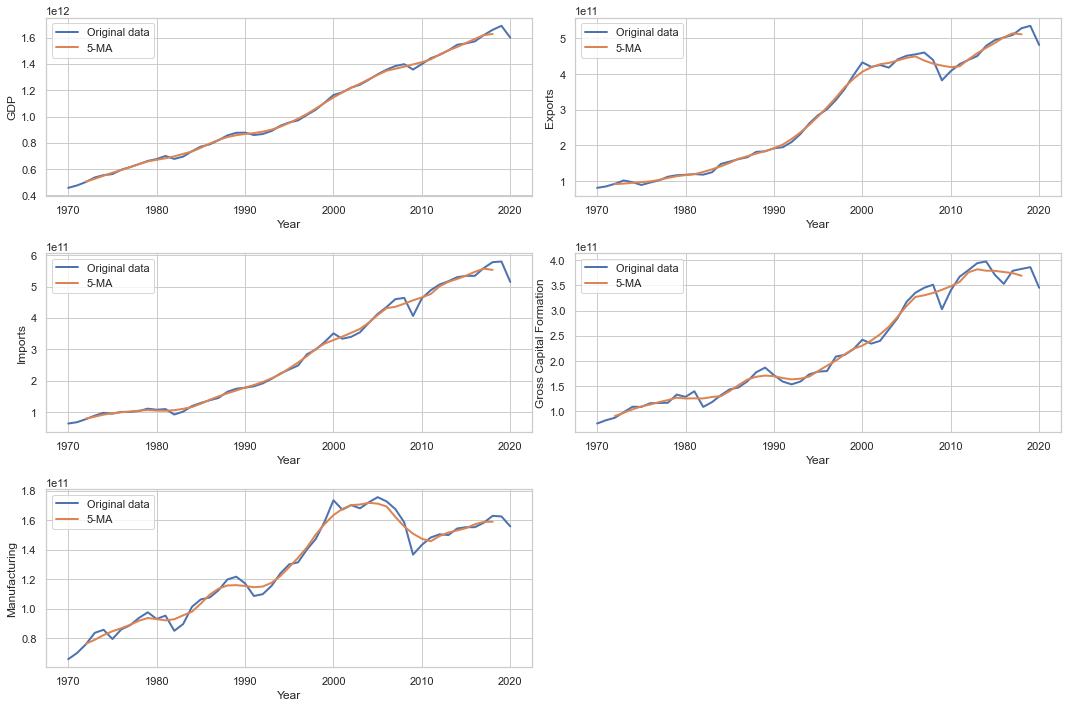

In [90]:
# Plot each original and smoothed variables to compare the TS
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# GDP
sns.lineplot(data=canada_gdp, x=canada_gdp.index, y='Value', ax=axes[0, 0], label='Original data', linewidth=2)
sns.lineplot(data=canada_gdp, x=canada_gdp.index, y='5-MA', ax=axes[0, 0], label='5-MA', linewidth=2)
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('GDP')
axes[0, 0].legend()

# Exports
sns.lineplot(data=exports_df, x=exports_df.index, y='Exports of goods and services', ax=axes[0, 1], label='Original data', linewidth=2)
sns.lineplot(data=exports_df, x=exports_df.index, y='5-MA', ax=axes[0, 1], label='5-MA', linewidth=2)
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Exports')
axes[0, 1].legend()

# Imports
sns.lineplot(data=imports_df, x=imports_df.index, y='Imports of goods and services', ax=axes[1, 0], label='Original data', linewidth=2)
sns.lineplot(data=imports_df, x=imports_df.index, y='5-MA', ax=axes[1, 0], label='5-MA', linewidth=2)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Imports')
axes[1, 0].legend()

# Gross Capital Formation
sns.lineplot(data=gcf_df, x=gcf_df.index, y='Gross capital formation', ax=axes[1, 1], label='Original data', linewidth=2)
sns.lineplot(data=gcf_df, x=gcf_df.index, y='5-MA', ax=axes[1, 1], label='5-MA', linewidth=2)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Gross Capital Formation')
axes[1, 1].legend()

# Manufacturing
sns.lineplot(data=man_df, x=man_df.index, y='Manufacturing (ISIC D)', ax=axes[2, 0], label='Original data', linewidth=2)
sns.lineplot(data=man_df, x=man_df.index, y='5-MA', ax=axes[2, 0], label='5-MA', linewidth=2)
axes[2, 0].set_xlabel('Year')
axes[2, 0].set_ylabel('Manufacturing')
axes[2, 0].legend()


axes[2, 1].axis('off')
plt.tight_layout()
plt.show()


## Forecasting

### Linear Regression

Since we are dealing with a time series, linear regression cannot be directly applied as the time information should be considered. Then, we can introduce a time dummy representing the years. It counts the steps in the series from the beginning to end.

In [91]:
canada_gdp['Year'] = range(canada_gdp.shape[0])
canada_gdp.head()

,Value,5-MA,Year
Date,,,
1970-01-01,4.581051e+11,NaN,0
1971-01-01,4.762930e+11,NaN,1
1972-01-01,5.025352e+11,5.056639e+11,2
1973-01-01,5.368873e+11,5.265632e+11,3
1974-01-01,5.544989e+11,5.504395e+11,4


Intercept 410194605009.0359
Slope 24917148130.036674


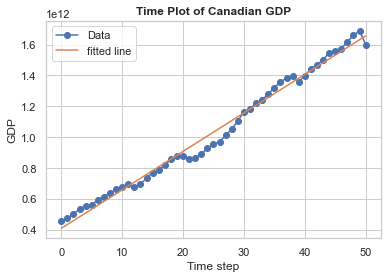

In [92]:
# Regression with the time dummy (Year)
x = canada_gdp['Year'].values
y = canada_gdp['Value'].values

x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

model = LinearRegression().fit(x,y)
print('Intercept', float(model.intercept_))
print('Slope', float(model.coef_))

fitted_line = model.predict(x)

plt.plot(x, y, marker='o',label='Data')
plt.grid()
plt.title('Time Plot of Canadian GDP',weight='bold');
plt.plot(x,fitted_line,label='fitted line');
plt.xlabel('Time step')
plt.ylabel('GDP')
plt.grid()
plt.legend();

In [93]:
# Use some evaluation metrics to assess the fitting results
print('R2 score is:', r2_score(y, fitted_line))
print('MSE value is:', mean_squared_error(y, fitted_line)) #understand how good the fit is
print('RMSE value is: ', np.sqrt(mean_squared_error(y, fitted_line)))

# Additional parameters to assess model performance
N = len(y)
n_params = x.shape[1]
error = np.sum((y - fitted_line)**2)

# Calculate AIC for regression
s2 = error/N
LL  = -N/2*(1+np.log(2*np.pi)+np.log(s2))
AIC = -2*LL + 2*(n_params+1)
print('Manual AIC:', float(AIC))

# Calculate BIC for regression
bic = -2*LL + (n_params+1)*np.log(N) # different penalty for the number of parameters compared to AIC
print('Manual BIC:',float(bic))

R2 score is: 0.9863199096798773
MSE value is: 1.8657778585880934e+21
RMSE value is:  43194650809.88725
Manual AIC: 2646.6079454566925
Manual BIC: 2650.471596722141


### Forecasting with Exponential Smoothing Models

We will use first ***Simple exponential smoothing***, and then compare it with ***Holt’s linear trend method (Double Exponential Smoothing)*** with damped trend (using additive method)

**Simple Exponential Smoothing**:
This method is suitable for forecasting data with no clear trend or seasonal pattern. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations are distant in the past. (i.e, the smallest weights are associated with the oldest observations).\
SES has one forecast equation and a single smoothing equation for the level.

In [108]:
# Train and Test split (last ten years)
canada_train_df = canada_gdp.Value[:-10]
canada_test_df= canada_gdp.Value[-10:]

print(canada_train_df.tail(3))
print(canada_test_df.head(3))

Date
2008-01-01    1.398140e+12
2009-01-01    1.357231e+12
2010-01-01    1.399168e+12
Freq: AS-JAN, Name: Value, dtype: float64
Date
2011-01-01    1.443188e+12
2012-01-01    1.468602e+12
2013-01-01    1.502807e+12
Freq: AS-JAN, Name: Value, dtype: float64


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74274D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.55450D+01    |proj g|=  5.95402D-13

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      2      2     0     1   5.954D-13   2.555D+01
  F =   25.545048685071421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


,Param Name,Values
0,smoothing_level,9.999000e-01
1,initial_level,4.360641e+11


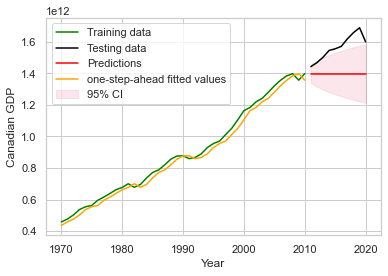

In [109]:
# Train the model and predictions
model = ETSModel(canada_train_df).fit()
predictions = model.forecast(10)

# Forecasting in the future and confidence interval
pred = model.get_prediction(start='2011-01-01', end='2020-01-01')
df = pred.summary_frame()

# Model parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)
display(tab)

# Plot
plt.plot(canada_train_df, color='green',label='Training data')
plt.plot(canada_test_df, color='black', label='Testing data')
plt.plot(predictions, color='red', label='Predictions')
plt.plot(model.fittedvalues,color='orange', label='one-step-ahead fitted values')
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Canadian GDP')
plt.legend();

**Holt’s linear trend method (Double Exponential Smoothing)**: extended SES method to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one for the level and one for the trend). To avoid over-forecast we use a parameter that “dampens” the trend to a flat line in the future.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.63042D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.52034D+01    |proj g|=  1.80000D-01

At iterate    2    f=  2.52003D+01    |proj g|=  1.72764D-01

At iterate    3    f=  2.51674D+01    |proj g|=  1.12360D-01

At iterate    4    f=  2.51581D+01    |proj g|=  1.22265D-01

At iterate    5    f=  2.51554D+01    |proj g|=  1.04518D-01

At iterate    6    f=  2.51506D+01    |proj g|=  8.11120D-02

At iterate    7    f=  2.51288D+01    |proj g|=  1.57625D-01

At iterate    8    f=  2.51201D+01    |proj g|=  4.68165D-02

At iterate    9    f=  2.51183D+01    |proj g|=  6.29274D-02

At iterate   10    f=  2.51107D+01    |proj g|=  4.20545D-02

At iterate   11    f=  2.51103D+01    |proj g|=  4.90559D-03

At iterate   12    f=  2.51103D+01    |proj g|=  9.00613D-04

At iterate   13    f=  2.5

,Param Name,Values
0,smoothing_level,9.999000e-01
1,smoothing_trend,1.541770e-01
2,damping_trend,9.800000e-01
3,initial_level,4.360641e+11
4,initial_trend,2.260947e+10


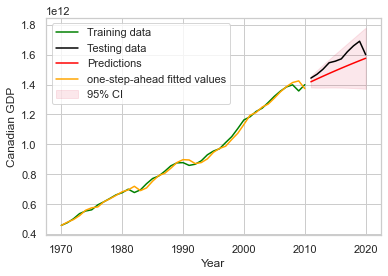

In [112]:
# Train the model and predictions (correct version)
Model = ETSModel(canada_train_df, trend='add', damped_trend=True).fit()
predictions = Model.forecast(10)

# Forecasting in the future and confidence interval
pred = Model.get_prediction(start='2011-01-01', end='2020-01-01')
df = pred.summary_frame()

# Model parameters
tab = {'Param Name': Model.param_names, 'Values': Model.params}
tab = pd.DataFrame(tab)
display(tab)

# Plot
plt.plot(canada_train_df, color='green',label='Training data')
plt.plot(canada_test_df, color='black', label='Testing data')
plt.plot(predictions, color='red', label='Predictions')
plt.plot(Model.fittedvalues,color='orange', label='one-step-ahead fitted values')
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Canadian GDP')
plt.legend();

In [111]:
# Comparing AIC
print('AIC Simple exponential smoothing:', model.aic)
print('AIC H+damped trend:', Model.aic)

# Comparing RMSE
print('RMSE Simple exponential smoothing:', np.sqrt(model.mse))
print('RMSE H+damped trend:', np.sqrt(Model.mse))

AIC Simple exponential smoothing: 2100.6939921758567
AIC H+damped trend: 2071.0431756431276
RMSE Simple exponential smoothing: 30049448705.927635
RMSE H+damped trend: 19454497157.133568


Evaluating both models with AIC and RMSE we can notice that the second one (the Holt Method with damped trend) is the best model to fit the data

### Forecasting with Arima Model

In [98]:
# Test for check stationarity: Augmented Dickey-Fuller test (ADF) and KPSS Test

result_ADF = adfuller(canada_train_df)
print('ADF p-value:', result_ADF[1])
if result_ADF[1] <= 0.05: #We reject the null hypothesis (H0), then data has not a unit root and is stationary.
  print('The TS is stationary')
else:
  print('The TS is not stationary')

print("\n")

kpss_test = kpss(canada_train_df, regression='ct', nlags='auto', store=True)
print('KPSS p-value: ', kpss_test[1])
if kpss_test[1] > 0.05: #we cannot reject null hypothesis, then the ts is trend stationary
  print('The TS is stationary')
else:
  print('The TS is not stationary')

#Time series is not stationary -> we can applied differenciation

ADF p-value: 0.9850250935991377
The TS is not stationary


KPSS p-value:  0.022272725798082673
The TS is not stationary


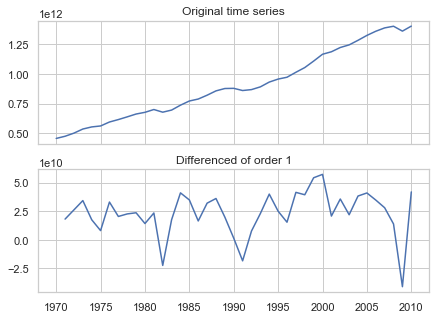

ADF Statistic: -4.752665791419427
ADF p-value: 6.693494030447512e-05
The TS is stationary


KPSS Statistic: 0.07402498924275953
KPSS p-value:  0.1
The TS is stationary


In [99]:
warnings.filterwarnings("ignore")

data_diff_1 = canada_train_df.diff().dropna()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
axs[0].plot(canada_train_df)
axs[0].set_title('Original time series')
axs[1].plot(data_diff_1)
axs[1].set_title('Differenced of order 1')
plt.show()

result_ADF = adfuller(data_diff_1)
print('ADF Statistic:', result_ADF[0])
print('ADF p-value:', result_ADF[1])
if result_ADF[1] < 0.05:
  print('The TS is stationary')
else:
  print('The TS is not stationary')

print("\n")

kpss_test = kpss(data_diff_1, regression='ct', nlags='auto', store=True)
print('KPSS Statistic:', kpss_test[0])
print('KPSS p-value: ', kpss_test[1])
if kpss_test[1] > 0.05:
  print('The TS is stationary')
else:
  print('The TS is not stationary')


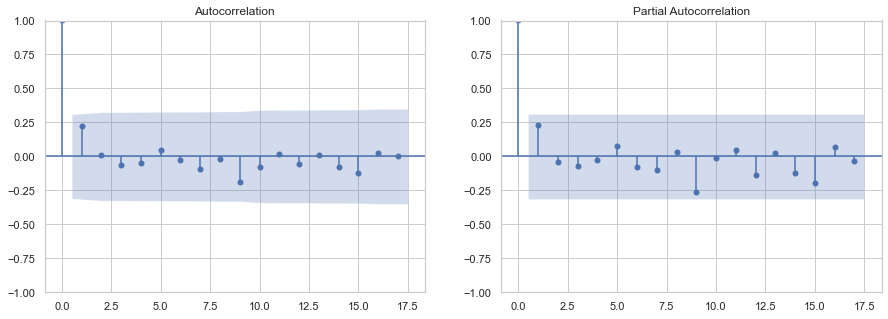

In [100]:
# ACF and PACF plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_acf(data_diff_1, ax=ax1);
plot_pacf(data_diff_1, ax=ax2);

In [101]:
#to choose the model parameters (in particular p and q) - Auto-ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

arima_model =  auto_arima(canada_train_df, start_p=0, d=0, start_q=0,
                          max_p=6, max_q=6, m=1, seasonal=False,
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = False,
                          random_state=20,information_criterion='aicc')

 ARIMA(0,0,0)(0,0,0)[0]             : AICC=2379.792, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=2356.566, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=2354.767, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AICC=2357.746, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AICC=2358.501, Time=0.04 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AICC=2367.404, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=2099.540, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=2091.626, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AICC=2092.012, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AICC=2094.651, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=2080.263, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AICC=inf, Time=0.18 sec
 ARIMA(3,0,0)(0

In [102]:
from statsmodels.tsa.arima.model import ARIMA

# Model parameter estimations
mod_ARIMA = ARIMA(canada_train_df, order=(2,1,2)).fit() #order of integration d=1 since a differencing of order 1 allow to make the TS stationary.

#Visualize the statistics and main results
print(mod_ARIMA.summary())
print('Estimated Coefficients:', mod_ARIMA.params)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   41
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1004.321
Date:                Wed, 07 Feb 2024   AIC                           2018.643
Time:                        12:42:30   BIC                           2027.087
Sample:                    01-01-1970   HQIC                          2021.696
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0006      0.267      0.002      0.998      -0.524       0.525
ar.L2          0.9994      0.259      3.854      0.000       0.491       1.508
ma.L1         -0.0016      0.899     -0.002      0.9

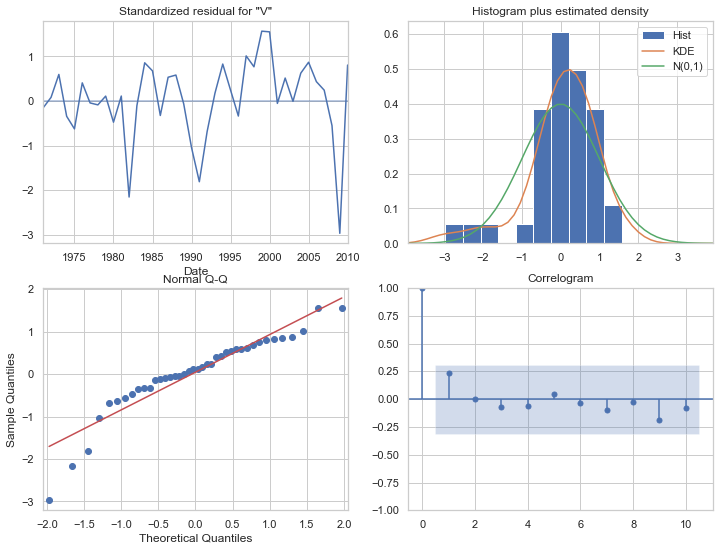

In [103]:
mod_ARIMA.plot_diagnostics(figsize=(12,9));

Here the Jarque-Bera Test (it checks if the sample data has the skewness and kurtosis matching a normal distribution) may not work well since we don't have a large sample (usually works with > 2000 observations). Here we have just 41 observations.

**Residuals’ diagnostics of the ARIMA(2,1,2) model.**

1. ***Standardazed Residual Plot:*** the plot shows that the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise.
2.  ***Histogram Plot:*** the plot shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak.
3. ***Q-Q plot:*** the plot displays a fairly straight line that lies on y = x (even if this plot works best with a large number of observations).
4. ***Correlogram:*** the plot shows no significant autocorrelation coefficients after lag 0, approximately looking like white noise.

In conclusion, the model seems to be a good fit for the Canadian GDP time series.

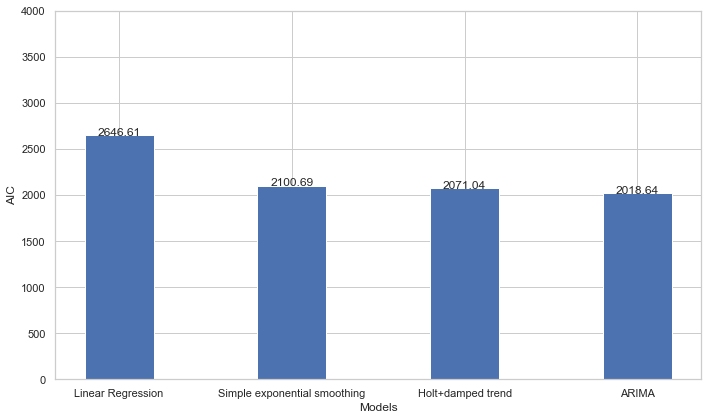

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
x = ['Linear Regression', 'Simple exponential smoothing', 'Holt+damped trend', 'ARIMA']
y = [float(AIC), model.aic, Model.aic, mod_ARIMA.aic]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('AIC')
ax.set_ylim(0, 4000)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

The best model seems to be the Arima

### Forecasting for all countries

In [105]:
#GDP of the 5 choosen countries
gdp = gdp_sub_df[gdp_sub_df['Name_indicator'].str.contains('gdp'.upper())]
gdp.tail()

,Country,Name_indicator,Value
Date,,,
2020-01-01,Canada,Gross Domestic Product (GDP),1.599940e+12
2020-01-01,China,Gross Domestic Product (GDP),1.463198e+13
2020-01-01,Italy,Gross Domestic Product (GDP),1.744732e+12
2020-01-01,Japan,Gross Domestic Product (GDP),4.380757e+12
2020-01-01,United States,Gross Domestic Product (GDP),1.924706e+13


In [106]:
#Creation of a pivot with all 5 countries under consideation
pivot_all = pd.pivot_table(data=gdp, index='Date',columns='Country', values='Value')
display(pivot_all.tail(5))

Country,Canada,China,Italy,Japan,United States
Date,,,,,
2016-01-01,1.571712e+12,1.181915e+13,1.859646e+12,4.478438e+12,1.850960e+13
2017-01-01,1.619490e+12,1.264025e+13,1.890662e+12,4.553466e+12,1.892712e+13
2018-01-01,1.658836e+12,1.349344e+13,1.908166e+12,4.578914e+12,1.947958e+13
2019-01-01,1.689714e+12,1.429637e+13,1.915995e+12,4.591291e+12,1.992544e+13
2020-01-01,1.599940e+12,1.463198e+13,1.744732e+12,4.380757e+12,1.924706e+13


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.63042D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.52034D+01    |proj g|=  1.80000D-01

At iterate    2    f=  2.52003D+01    |proj g|=  1.72764D-01

At iterate    3    f=  2.51674D+01    |proj g|=  1.12360D-01

At iterate    4    f=  2.51581D+01    |proj g|=  1.22265D-01

At iterate    5    f=  2.51554D+01    |proj g|=  1.04518D-01

At iterate    6    f=  2.51506D+01    |proj g|=  8.11120D-02

At iterate    7    f=  2.51288D+01    |proj g|=  1.57625D-01

At iterate    8    f=  2.51201D+01    |proj g|=  4.68165D-02

At iterate    9    f=  2.51183D+01    |proj g|=  6.29274D-02

At iterate   10    f=  2.51107D+01    |proj g|=  4.20545D-02

At iterate   11    f=  2.51103D+01    |proj g|=  4.90559D-03

At iterate   12    f=  2.51103D+01    |proj g|=  9.00613D-04

At iterate   13    f=  2.5

,AIC,RMSE
Canada,2071.043176,1.945450e+10


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.90376D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.62958D+01    |proj g|=  1.92793D-01

At iterate    2    f=  2.61934D+01    |proj g|=  9.96689D-02

At iterate    3    f=  2.61497D+01    |proj g|=  2.77626D-02

At iterate    4    f=  2.61384D+01    |proj g|=  1.04344D-13

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      5      8     0     3   1.043D-13   2.614D+01
  F =   26.138432500207976     

CONVERG

,AIC,RMSE
China,2155.351465,5.439260e+10


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.59397D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.56455D+01    |proj g|=  2.74535D-01

At iterate    2    f=  2.56054D+01    |proj g|=  1.80000D-01

At iterate    3    f=  2.55848D+01    |proj g|=  1.23296D-01

At iterate    4    f=  2.55804D+01    |proj g|=  9.77220D-02

At iterate    5    f=  2.55650D+01    |proj g|=  1.05483D-01

At iterate    6    f=  2.54934D+01    |proj g|=  2.26414D-12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

,AIC,RMSE
Italy,2102.461536,2.853779e+10


          
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.75097D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.65048D+01    |proj g|=  2.43661D-01

At iterate    2    f=  2.64955D+01    |proj g|=  2.31283D-01

At iterate    3    f=  2.64715D+01    |proj g|=  1.11386D-01

At iterate    4    f=  2.64672D+01    |proj g|=  8.90166D-02

At iterate    5    f=  2.64613D+01    |proj g|=  1.80000D-01

At iterate    6    f=  2.64502D+01    |proj g|=  1.87093D-02

At iterate    7    f=  2.64483D+01    |proj g|=  1.29173D-01

At iterate    8    f=  2.64482D+01    |proj g|=  4.01634D-03

At iterate    9    f=  2.64481D+01    |proj g|=  2.81325D-03

At iterate   10    f=  2.64481D+01    |proj g|=  5.69145D-04

At iterate   11    f=  2.64481D+01    |proj g|=  1.88294D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of 

,AIC,RMSE
Japan,2180.74791,7.413894e+10


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.89545D+01    |proj g|=  8.99900D-01

At iterate    1    f=  2.75936D+01    |proj g|=  1.92793D-01

At iterate    2    f=  2.75737D+01    |proj g|=  1.55455D-01

At iterate    3    f=  2.75557D+01    |proj g|=  1.11716D-01

At iterate    4    f=  2.75475D+01    |proj g|=  1.01404D-01

At iterate    5    f=  2.75353D+01    |proj g|=  1.41891D-01

At iterate    6    f=  2.75333D+01    |proj g|=  1.28660D-01

At iterate    7    f=  2.75241D+01    |proj g|=  8.72014D-02

At iterate    8    f=  2.75015D+01    |proj g|=  7.75287D-02

At iterate    9    f=  2.74980D+01    |proj g|=  6.39062D-03

At iterate   10    f=  2.74980D+01    |proj g|=  3.49765D-03

At iterate   11    f=  2.74980D+01    |proj g|=  9.76996D-05

At iterate   12    f=  2.74980D+01    |proj g|=  1.42109D-06

           * * *

Tit   = 

,AIC,RMSE
United States,2266.832869,2.118244e+11


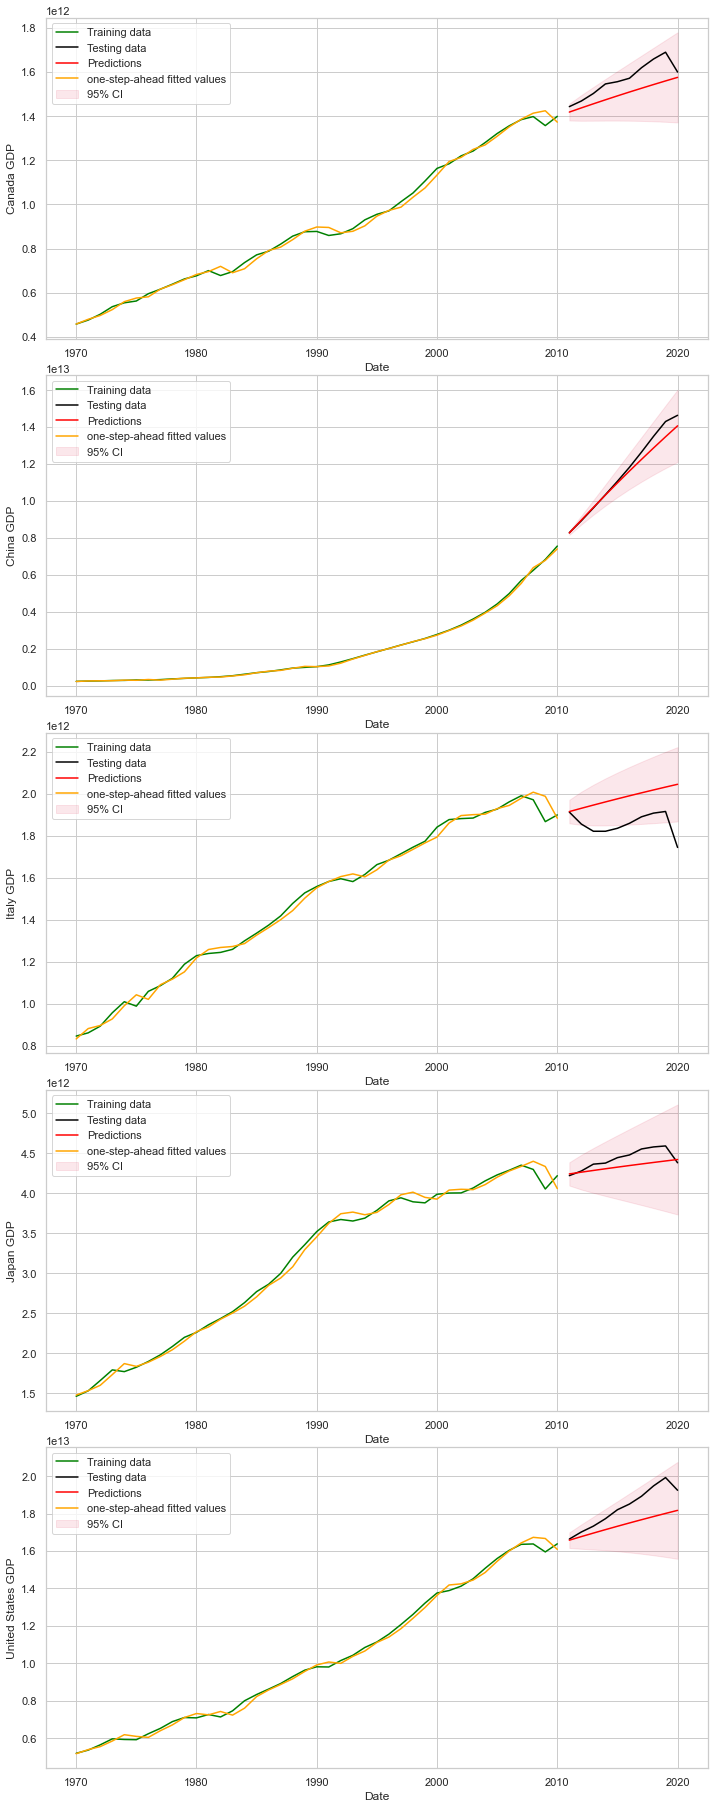

In [107]:
fig, ax = plt.subplots(5,1, figsize=(10,25))
fig.tight_layout()

n=0
for i in pivot_all.columns:
  piv = pivot_all[i].asfreq('AS')
  data_train = piv[:-10]
  data_test = piv[-10:]
  Mod = ETSModel(data_train, trend='add', damped_trend=True).fit()
  predictions = Mod.forecast(10)
  predic = Mod.get_prediction(start='2011-01-01', end='2020-01-01')
  df = predic.summary_frame()
  ax[n].plot(data_train, color='green',label='Training data')
  ax[n].plot(data_test, color='black', label='Testing data')
  ax[n].plot(predictions, color='red', label='Predictions')
  ax[n].plot(Mod.fittedvalues,color='orange', label='one-step-ahead fitted values')
  ax[n].fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
  ax[n].set_xlabel('Date')
  ax[n].set_ylabel(str(pivot_all.columns[n])+' GDP')
  ax[n].legend()
  tab = {'AIC': [Mod.aic], 'RMSE': [np.sqrt(Mod.mse)]}
  tab = pd.DataFrame(tab, index=[str(pivot_all.columns[n])])
  display(tab)
  n+=1